<a href="https://colab.research.google.com/github/kumiori/mec647/blob/Wissam-meshes/project_3crackhole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [ ]:
#Numpy -> numerical library for Python. We'll use it for all array operations.
#It's written in C and it's faster (than traditional Python)
import numpy as np

#Yaml (Yet another markup language) -> We'll use it to pass, read and structure
#light text data in .yml files.
import yaml

#Json -> Another form to work with data. It comes from JavaScript. Similar functions
#that Yaml. Used speacily with API request, when we need data "fetch".
import json

#Communication with the machine:
#Sys -> allows to acess the system and launch commandes.
#Os - > allows to acess the operation system.
import sys
import os
from pathlib import Path

#Mpi4py -> Interface that allows parallel interoperability. MPI stands for' Message
#Passager Interface' and will be used to communicate computer nodes when lauching code
#in a parallel way

from mpi4py import MPI
#Petcs4py -> we use this library to handle with the data. Given acesses to solvers
import petsc4py
from petsc4py import PETSc

#Dolfinx
import dolfinx
import dolfinx.plot
from dolfinx import log
import logging

logging.basicConfig(level=logging.INFO)
import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

#UFL (Unified Format Language) -> we'll be used to represent abstract way to 
#represent the language in a quadratic form
import ufl

#XDMFF -> format used for the output binary data
from dolfinx.io import XDMFFile

#Install 'gmsh' library -> we'll be used for the mesh.
#!{sys.executable}: to use the current kernel to make the installation 
try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

import matplotlib.pyplot as plt

In [ ]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

In [ ]:
!rm -rf mec647

try:
  !git clone https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')

  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git

Cloning into 'mec647'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (556/556), done.
remote: Compressing objects: 100% (456/456), done.
remote: Total 556 (delta 241), reused 242 (delta 81), pack-reused 0
Receiving objects: 100% (556/556), 7.27 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [ ]:
sys.path.append('mec647/')

In [ ]:
from utils.viz import plot_mesh

In [ ]:

from mpi4py import MPI


def mesh_3crackhole(name,
                     Lx,
                     Ly,
                     lc,
                     tdim,
                     order=1,
                     msh_file=None,
                     comm=MPI.COMM_WORLD):
    """
    Create mesh of 3d tensile test specimen according to ISO 6892-1:2019 using the Python API of Gmsh.
    """
    # Perform Gmsh work only on rank = 0

    if comm.rank == 0:

        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        gmsh.option.setNumber("Mesh.Algorithm", 6)
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
        p1 = model.geo.addPoint(0, 0.0, 0,1.0, tag=1)
        p2 = model.geo.addPoint(1, 0.0, 0,1.0, tag=2)
        p3 = model.geo.addPoint(1.0,0.5, 0.0,1, tag=3)
        p4 = model.geo.addPoint(0,0.5, 0.0,1, tag=4)
        p5 = model.geo.addPoint(0, 0.275, 0, 1, tag=5)
        p6 = model.geo.addPoint(0.25,0.275, 0,0.5, tag=6)
        p7 = model.geo.addPoint(0.35, 0.251, 0.0,0.2, tag=7)
        p8 = model.geo.addPoint(0.35,0.249, 0,0.2, tag=8)
        p9 = model.geo.addPoint(0.75,0.25, 0,0.2, tag=9)
        p10= model.geo.addPoint(0.25,0.225,0,0.5, tag=10)
        p11= model.geo.addPoint(0,0.225,0,1, tag=11)
        # points = [p1, p2, p3, p4, p5, p6, p7, p8,p9,p10,p11]
        bottom = model.geo.addLine(p1, p2, tag=1)
        right = model.geo.addLine(p2, p3, tag=2)
        top = model.geo.addLine(p3, p4, tag=3)
        left1 = model.geo.addLine(p4, p5, tag=4)
        halftop = model.geo.addLine(p5, p6, tag=5)
        inclined1 = model.geo.addLine(p6, p7, tag=6)
        liptop = model.geo.addLine(p7, p8, tag=7)
        lipbot = model.geo.addLine(p8, p9, tag=8)
        inclined2 = model.geo.addLine(p9, p10, tag=9)
        halfbottom = model.geo.addLine(p10, p11, tag=10)
        left2 = model.geo.addLine(p11, p1, tag=11)
        cloop1 = model.geo.addCurveLoop([bottom, right, top, left1, halftop, inclined1, liptop, lipbot, inclined2,halfbottom, left2])
        # surface_1 =
        model.geo.addPlaneSurface([cloop1])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(tdim)]
        model.addPhysicalGroup(tdim, surface_entities, tag=7)
        model.addPhysicalGroup(tdim, surface_entities, tag=8)
        model.setPhysicalName(tdim, 7, "liptop")
        model.setPhysicalName(tdim, 8, "lipbot")

        # Set mesh size via points
        # gmsh.model.mesh.setSize(points, lc)  # heuristic

        # gmsh.model.mesh.optimize("Netgen")

        # Set geometric order of mesh cells
        gmsh.model.mesh.setOrder(order)
        model.geo.synchronize()


        

        model.mesh.generate(tdim)

        # Optional: Write msh file
        if msh_file is not None:
            gmsh.write(msh_file)
            # gmsh.write(name + ".step")

    return gmsh.model if comm.rank == 0 else None, tdim



In [ ]:
gmsh_model = mesh_3crackhole('mesh' ,1, 0.5, 1, 2,1)


In [ ]:
print (mesh_3crackhole)

<function mesh_3crackhole at 0x7f1d0c8f37a0>


In [ ]:
xvfb.start_xvfb(wait=0.05)
pyvista.off_screen=True
import pyvista 
from pyvista.utilities import xvfb
from utils.viz import plot_vector


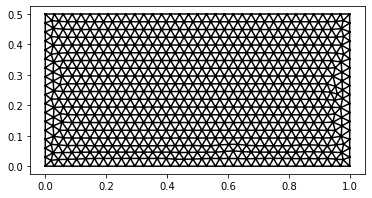

In [ ]:

# TODO: Plot mesh


plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")